In [1]:
import os
os.chdir("/data/t-achetan/adv_geom/src/")
import numpy as np
import torch

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
from datagen.synthetic.multiple.intertwinedswissrolls import IntertwinedSwissRolls

26-06-2022 17:31:18 -- [I] faiss.loader | [loader.py:54 -             <module>()] >> Loading faiss with AVX2 support.
26-06-2022 17:31:18 -- [I] faiss.loader | [loader.py:56 -             <module>()] >> Successfully loaded faiss with AVX2 support.


In [3]:
# config = {
#     "N": 10000,
#     "num_neg": None,
#     "n": 2,
#     "k": 2,
#     "D": 0.2,
#     "max_norm": 0.4,
#     "contract": 1,
#     "mu": 0,
#     "sigma": 1,
#     "seed": 23,
#     "gamma": 0.5,
#     "t_min": 1.5,
#     "t_max": 4.5,
#     "num_turns": None,
#     "omega": np.pi,
#     "inferred": True
# }

config = {
    "N": 500200,
    "num_neg": 200,
    "n": 500,
    "k": 50,
    "D": 20,
    "max_norm": 40,
    "contract": 100,
    "mu": 0,
    "sigma": 1,
    "seed": 23,
    "gamma": 0.5,
    "t_min": 150,
    "t_max": 450,
    "height": 21,
    "num_turns": None,
    "omega": np.pi * 0.01,
    "inferred": True,
    "online": False,
    "off_online": False,
    "augment": False,
    "gamma": 0
}

In [4]:
test_swrolls = IntertwinedSwissRolls(**config)

In [5]:
test_swrolls.compute_points()

26-06-2022 17:31:18 -- [I] root | [swissroll.py:545 -       compute_points()] >> [RandomSwissRoll]: swiss roll attribute setup done
26-06-2022 17:31:19 -- [I] root | [swissroll.py:547 -       compute_points()] >> [RandomSwissRoll]: generated points in k-dim
26-06-2022 17:31:19 -- [I] root | [intertwinedswissrolls.py:429 -       compute_points()] >> [IntertwinedSwissRolls]: Generated S1
26-06-2022 17:31:19 -- [I] root | [swissroll.py:545 -       compute_points()] >> [RandomSwissRoll]: swiss roll attribute setup done
26-06-2022 17:31:19 -- [I] root | [swissroll.py:547 -       compute_points()] >> [RandomSwissRoll]: generated points in k-dim
26-06-2022 17:31:19 -- [I] root | [intertwinedswissrolls.py:440 -       compute_points()] >> [IntertwinedSwissRolls]: Generated S2
26-06-2022 17:31:19 -- [I] root | [intertwinedswissrolls.py:505 -           _inf_setup()] >> [IntertwinedSwissRolls]: made poca_idx
26-06-2022 17:31:20 -- [I] root | [intertwinedswissrolls.py:507 -           _inf_setup()] 

In [6]:
test_swrolls.all_tang_and_norms[-100][-1]

array([ 7.07809412e-01, -7.06403451e-01, -2.64617553e-05])

In [13]:
def compute_normals(SW):
    """
    analytical expression for the swiss roll is given by:

    $$
    \\vector{v} = 
                \[
                    g(t) cos(\pi t) \\
                    g(t) sin(\pi t) \\
                        \psi
                \]
    $$

    In order to find the normal direction to this surface, we first find
    $\partial{\vector{v}}{t}$ and $\partial{\vector{v}}{psi}$ and then take
    their cross-products
    """

    g = SW._specattrs.g
    d_g = SW._specattrs.d_g
    t = SW._specattrs.t
    omega = SW._specattrs.omega
    N = t.shape[0]
    k = SW._genattrs.k

    # components of partial of v w.r.t t (apart from x, y all other components are 0!)
    dv_t_x =  (d_g(t) * np.cos(omega * t)) - (omega * g(t) * np.sin(omega * t))
    dv_t_y =  (d_g(t) * np.sin(omega * t)) + (omega * g(t) * np.cos(omega * t))

    # taking cross product of dv_t and dv_psi, the net result is as given below
    normal_vectors_to_mfld_at_p = np.zeros((N, k))
    normal_vectors_to_mfld_at_p[:, 0] = dv_t_y
    normal_vectors_to_mfld_at_p[:, 1] = -1 * dv_t_x

    # scaling to self._specattrs.max_norm for ease of visualisation
    scaling_factor = (SW._genattrs.max_norm / (np.linalg.norm(normal_vectors_to_mfld_at_p, axis=1, ord=2))).reshape(-1, 1)
    normal_vectors_to_mfld_at_p = scaling_factor * normal_vectors_to_mfld_at_p

    embedded_normal_vectors_to_mfld_at_p = np.zeros((SW._genattrs.N - SW._genattrs.num_neg, SW._genattrs.n))
    embedded_normal_vectors_to_mfld_at_p[:, :SW._genattrs.k] = normal_vectors_to_mfld_at_p

    return embedded_normal_vectors_to_mfld_at_p

true_normals = compute_normals(test_swrolls.S2)[-10]

In [12]:
test_swrolls.S1.specattrs.t[test_swrolls.nn_indices[100]]

array([343.03806305, 341.63759505, 344.62384834, 342.39391548,
       343.99874387, 343.70909387, 342.7433832 , 342.7082576 ,
       344.07160358, 342.7283212 , 342.741477  , 343.02549129,
       344.01823859, 343.49274937, 343.65734   , 342.1361943 ,
       343.47839565, 341.94384445, 342.99417159, 343.23091973,
       343.82457611, 342.34050807, 342.93904321, 341.82623801,
       341.88376159, 343.16497143, 343.78889719, 343.45456444,
       344.47519728, 343.66613707, 343.26222069, 343.65853679,
       343.46809706, 341.33698041, 342.98879047, 342.83992243,
       341.9452323 , 344.62740336, 343.74723428, 342.80763874,
       344.12725281, 342.431466  , 344.63476567, 342.02240062,
       343.54603236, 341.97331796, 344.63129071, 341.19005517,
       341.26496531, 343.67790702, 343.53814503])

In [14]:
np.dot(true_normals / np.linalg.norm(true_normals, 2), test_swrolls.all_tang_and_norms[-10][-1])

0.999999788958491

In [15]:
true_normals / np.linalg.norm(true_normals, 2), test_swrolls.S2.specattrs.t[-1], test_swrolls.all_points_trivial_[-1]

(array([-0.36946384,  0.92924511,  0.        ]),
 197.30688365074653,
 tensor([96.9588, -8.2230, 17.2660]))

In [24]:
np.arange(test_swrolls.S1.genattrs.N - test_swrolls.S1.genattrs.num_neg, test_swrolls.num_pos)

array([250000, 250001, 250002, ..., 499997, 499998, 499999])

In [23]:
test_swrolls.poca_idx[:100], test_swrolls.poca_idx[100:]

(array([ 61560,  85044,  75033,   2969, 108246, 226241, 174725, 219504,
         79016, 134603, 106856, 159180,  77068, 147628,  63956, 185160,
        224927,  11824, 127689,  38195, 109527, 124828, 223555, 173836,
         40862, 130588, 178450,  46731, 105588, 214539,  64838, 175675,
        198539,  77847, 121151,  86593, 145714, 156597, 110572, 225268,
        207341, 196628, 116381,  28606, 128193,  92005, 244250, 183809,
         27489, 239136,  96913,  97884, 248700, 201173,  19753, 221709,
        161855, 173684, 183484, 166934, 222164,  17397,  75572, 185315,
        112057,  71936, 173349,  54288,  76140, 190667,  78974, 234695,
        220910, 189703, 187760, 127070,  43656, 163239, 144369, 243922,
        169729, 183366, 203969,  55595, 199052, 208766,  18358, 165187,
        213787, 198271, 246455,   9210, 128190, 124748, 192962,  54536,
         18289, 108028,  11046, 211187]),
 array([399220, 455905, 397887, 318014, 367293, 394197, 271264, 342309,
        327978, 432370

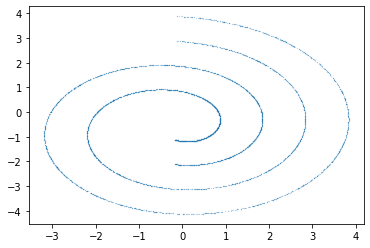

In [22]:
plt.scatter(test_swrolls.on_mfld_pts_trivial_[:, 0] + test_swrolls.translation[0], test_swrolls.on_mfld_pts_trivial_[:, 1] + test_swrolls.translation[1], s=0.01)

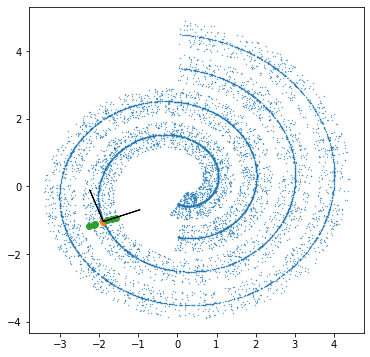

In [33]:
plt.figure(figsize=(6, 6))
plt.scatter(test_swrolls.all_points_trivial_[:, 0], test_swrolls.all_points_trivial_[:, 1], s=0.1)
plt.scatter(test_swrolls.all_points_trivial_[-1, 0], test_swrolls.all_points_trivial_[-1, 1])
plt.arrow(test_swrolls.all_points_trivial_[-1, 0], test_swrolls.all_points_trivial_[-1, 1], test_swrolls.all_tang_and_norms[-1][0, 0], test_swrolls.all_tang_and_norms[-1][0, 1])
plt.arrow(test_swrolls.all_points_trivial_[-1, 0], test_swrolls.all_points_trivial_[-1, 1], test_swrolls.all_tang_and_norms[-1][1, 0], test_swrolls.all_tang_and_norms[-1][1, 1])

# plt.arrow(test_swrolls.all_points_trivial_[-1, 0], test_swrolls.all_points_trivial_[-1, 1], test_swrolls.on_mfld_pb[-1][0, 0], test_swrolls.on_mfld_pb[-1][0, 1], linewidth=5)
# plt.arrow(test_swrolls.all_points_trivial_[-1, 0], test_swrolls.all_points_trivial_[-1, 1], test_swrolls.off_mfld_pb[-1][1, 0], test_swrolls.off_mfld_pb[-1][1, 1], linewidth=5)


plt.scatter(test_swrolls.off_mfld_pts_for_chunk[-1][:, 0], test_swrolls.off_mfld_pts_for_chunk[-1][:, 1])

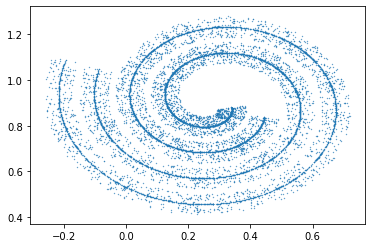

In [35]:
plt.scatter(test_swrolls.normed_all_points[:, 0], test_swrolls.normed_all_points[:, 1], s=0.1)

In [28]:
test_swrolls.on_mfld_pb[-1]

tensor([[ 1.1885e-04, -3.1740e-04],
        [-1.1367e-04,  3.0358e-04],
        [-9.1518e-05,  2.4442e-04],
        [-2.6055e-04,  6.9584e-04],
        [ 9.4028e-05, -2.5112e-04],
        [-2.0382e-04,  5.4436e-04]], dtype=torch.float64)

In [ ]:
test_spheres.class_labels

In [ ]:
np.linalg.norm(test_spheres.all_points_rot_[:100] - test_spheres.x_cn, axis=1) - 1.

In [ ]:
test_spheres.class_labels

In [ ]:
np.linalg.norm(test_spheres.normed_all_points[10000:15000] - test_spheres.fix_center, ord=2, axis=1) - 1.3




In [ ]:
test_spheres.normed_all_actual_distances[10000:15000]

In [ ]:
np.where(test_spheres.normed_all_actual_distances[test_spheres.class_labels == 2][:, 0] > 0.1)[0].shape

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(test_spheres.on_mfld_pts_trivial_[:, 0], test_spheres.on_mfld_pts_trivial_[:, 1], s=0.01)
idx = 2000
plt.scatter(test_spheres.poca[idx][0], test_spheres.poca[idx][1])
tan_dir_local = test_spheres.tang_dset[test_spheres.poca_idx[idx]][0]
norm_dir_local = test_spheres.norm_dset[test_spheres.poca_idx[idx]][0]

plt.arrow(test_spheres.poca[idx][0], test_spheres.poca[idx][1], tan_dir_local[0], tan_dir_local[1])
plt.arrow(test_spheres.poca[idx][0], test_spheres.poca[idx][1], norm_dir_local[0], norm_dir_local[1])

on_mfld_pt = test_spheres.poca[idx]
norm_dir = test_spheres.norm_dset[test_spheres.poca_idx[idx]]
rdm_coeffs = np.random.normal(0, 1, size=norm_dir.shape[0]).reshape(-1, 1)
norm_delta = np.sum(rdm_coeffs * norm_dir, axis=0)
off_mfld_pt = on_mfld_pt + norm_delta

plt.scatter(test_spheres.new_poca_dset[idx][0], test_spheres.new_poca_dset[idx][1])
# off_mfld_idx = idx if idx < test_spheres.S1.genattrs.num_neg else idx + (test_spheres.S1.genattrs.N - test_spheres.S1.genattrs.num_neg)
# plt.scatter(test_spheres.all_points[idx][0], test_spheres.all_points[idx][1])
plt.scatter(off_mfld_pt[0], off_mfld_pt[1])

In [ ]:
test_spheres.all_tang_and_norms[-1]

In [ ]:
test_spheres.all_points_trivial_[-1] / np.linalg.norm(test_spheres.all_points_trivial_[-1], ord=2)

In [ ]:
test_spheres.x_cn

In [ ]:
np.random.choice([1, 2, 3, 4, 5, 6], size=4)

In [ ]:
np.where(test_spheres == 2)[0].shape

# Testing inferred manifold generation code on 06/05/2022

In [4]:
dir_name = "/mnt/t-achetan/expC_dist_learner_for_adv_ex/rdm_swrolls_test/rdm_swrolls_k2n500_noninfdist_moreoffmfld__bs4096_inferred_maxtdelta=1e=3/data"
train_set, val_set, test_set = IntertwinedSwissRolls.load_splits(dir_name)



In [8]:
test_set.max_norm / test_set.norm_factor

0.056583759614427305

In [ ]:
test_set.max_norm / test_set.norm_factor

In [59]:
train_set.on_mfld_pts_trivial_[0]

array([-3.01142623, -0.49534523,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [78]:
import scipy.linalg as spla
nbhr_indices = np.argsort(np.linalg.norm(train_set.on_mfld_pts_trivial_[0] - train_set.on_mfld_pts_trivial_[1:], axis=1))[:2]
nbhrs = train_set.on_mfld_pts_trivial_[nbhr_indices]
nbhr_local_coords = nbhrs - train_set.on_mfld_pts_trivial_[0]
pca = PCA(n_components=1)
pca.fit(nbhr_local_coords)
tang_dir = pca.components_
normal_dirs = spla.null_space(pca.components_).T

In [79]:
normal_dirs

array([[-0.60129423,  0.79902769,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ]])

In [81]:
tang_dir

array([[ 0.79902769,  0.60129423, -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0. 

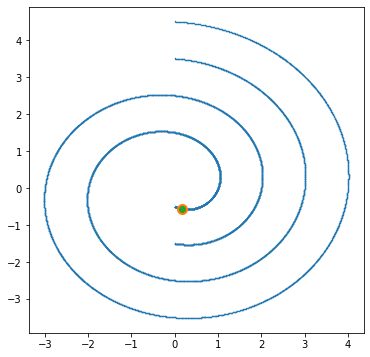

In [82]:
plt.figure(figsize=(6, 6))

onmfld_idx = -200
plt.scatter(train_set.on_mfld_pts_k_[:, 0], train_set.on_mfld_pts_k_[:, 1], s=0.01)
plt.scatter(train_set.on_mfld_pts_k_[:, 0][onmfld_idx], train_set.on_mfld_pts_k_[:, 1][onmfld_idx], s=100)
# plt.arrow(train_set.on_mfld_pts_k_[:, 0][onmfld_idx], train_set.on_mfld_pts_k_[:, 1][onmfld_idx], train_set.all_tang_and_norms[onmfld_idx][0][0], train_set.all_tang_and_norms[onmfld_idx][0][1])
# plt.arrow(train_set.on_mfld_pts_k_[:, 0][onmfld_idx], train_set.on_mfld_pts_k_[:, 1][onmfld_idx], train_set.all_tang_and_norms[onmfld_idx][1][0], train_set.all_tang_and_norms[onmfld_idx][1][1])
# plt.scatter(train_set.new_poca_dset[idx][0], train_set.new_poca_dset[idx][1])
# plt.arrow(train_set.on_mfld_pts_k_[:, 0][onmfld_idx], train_set.on_mfld_pts_k_[:, 1][onmfld_idx], train_set.on_mfld_pb[onmfld_idx][1][0], train_set.on_mfld_pb[onmfld_idx][1][1], linewidth=5)
# plt.arrow(train_set.on_mfld_pts_k_[:, 0][onmfld_idx], train_set.on_mfld_pts_k_[:, 1][onmfld_idx], train_set.off_mfld_pb[onmfld_idx][1][0], train_set.off_mfld_pb[onmfld_idx][1][1], linewidth=5)

plt.scatter(train_set.all_points_trivial_[:, 0][onmfld_idx], train_set.all_points_trivial_[:, 1][onmfld_idx])
# plt.scatter(train_set.off_mfld_pts_for_chunk[onmfld_idx][:, 0], train_set.off_mfld_pts_for_chunk[onmfld_idx][:, 1])

In [ ]:
train_set.all_tang_and_norms[-1]

In [ ]:
np.dot(train_set.on_mfld_pts_trivial_[-1] / np.linalg.norm(train_set.on_mfld_pts_trivial_[-1]), train_set.all_tang_and_norms[-1][-1])

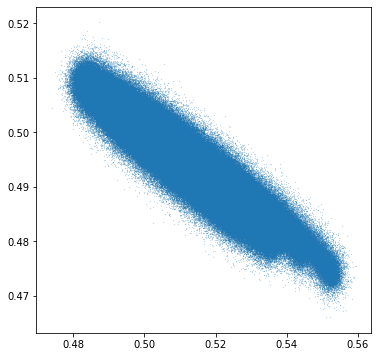

In [5]:
plt.figure(figsize=(6, 6))
plt.scatter(train_set.normed_all_points[:, 0], train_set.normed_all_points[:, 1], s=0.01)


In [ ]:
plt.scatter(train_set.all_points_trivial_[:, 0][train_set.class_labels == 2], train_set.all_points_trivial_[:, 1][train_set.class_labels == 2], s=0.01)
plt.scatter(train_set.on_mfld_pts_k_[train_set.poca_idx, 0], train_set.on_mfld_pts_k_[train_set.poca_idx, 1], s=0.01)


In [41]:
train_set.max_norm, train_set.norm_factor

(0.4, 8.668068408966064)

In [ ]:
train_set.all_points.shape

In [ ]:
train_set.off_mfld_pts_for_chunk.shape

In [ ]:
train_set.off_mfld_pts_for_chunk[:, 0].shape

In [ ]:
train_set.on_mfld_pb.shape

In [ ]:
train_set.on_mfld_pts_k_[:1] + train_set.off_mfld_pb[:1].numpy()

In [ ]:
train_set.off_mfld_pb[:1].numpy()

In [ ]:
train_set.on_mfld_pts_k_[:1]

In [ ]:
a = np.zeros((2, 500))
a[0, :] = 1
a[1, :] = 2
b = np.zeros((2, 7, 500))
(np.expand_dims(a, 1) + b).reshape(-1, 500)

In [ ]:
(np.expand_dims(train_set.on_mfld_pts_k_[5000:], 1) + (np.expand_dims(train_set.on_mfld_pb_sizes / np.linalg.norm(train_set.on_mfld_pb, axis=-1), axis=-1) * train_set.on_mfld_pb.numpy())) + train_set.off_mfld_pb.numpy()




In [51]:
torch.min(torch.norm(train_set.all_points[25000] - train_set.all_points[75000:], dim=1))

tensor(0.9921)

In [50]:
np.unique(train_set.class_labels, return_counts=True)

(array([0, 1, 2]), array([25000, 25000, 50000]))

In [56]:
a = np.random.normal(size=(2,1000, 1000))
np.linalg.qr(a)[0]

LinAlgError: 3-dimensional array given. Array must be two-dimensional

In [55]:
np.dot(np.linalg.qr(a)[0], a.T).T.shape

(1000, 1000)

In [10]:
train_set.max_norm / train_set.norm_factor

0.056583759614427305

In [24]:
torch.max(train_set.normed_all_actual_distances[train_set.class_labels == 2][:500000, 0])

tensor(0.0566)

In [16]:
len(train_set)

1050000

In [21]:
train_set.normed_all_actual_distances[train_set.class_labels == 2].shape

torch.Size([1000000, 2])

In [6]:
train_set.normed_all_points

tensor([[0.5123, 0.4887, 0.5038,  ..., 0.5019, 0.4765, 0.5026],
        [0.5130, 0.4899, 0.5036,  ..., 0.5009, 0.4786, 0.5069],
        [0.5116, 0.4901, 0.5036,  ..., 0.5007, 0.4777, 0.5059],
        ...,
        [0.5097, 0.4988, 0.4766,  ..., 0.4733, 0.5027, 0.5071],
        [0.5217, 0.4927, 0.4610,  ..., 0.4555, 0.4948, 0.5142],
        [0.5110, 0.4954, 0.4852,  ..., 0.4822, 0.4937, 0.5069]])

RuntimeError: [enforce fail at alloc_cpu.cpp:73] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 950000000000 bytes. Error code 12 (Cannot allocate memory)

In [34]:
train_set.class_labels

tensor([2, 2, 2,  ..., 1, 1, 1])